# Lecture 9: Ridge and Lasso Regularization in Scikit-Learn
***

<img src="figs/cogs.jpg" width=1100 height=50>

**Reminder**:  Go to the botttom of the notebook and shift-enter the helper functions.
***

In [2]:
import numpy as np
import pickle
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline

### Problem 1: Dam Ridge Regression
***

We'll again study the data set describing water level in a damn to the rate of flow of water through the damn. First we'll load the data which is stored in a serialized format in the data directory.  We'll store the features in a 2D Numpy array $X$ and the response in a 1D Numpy array $y$. 

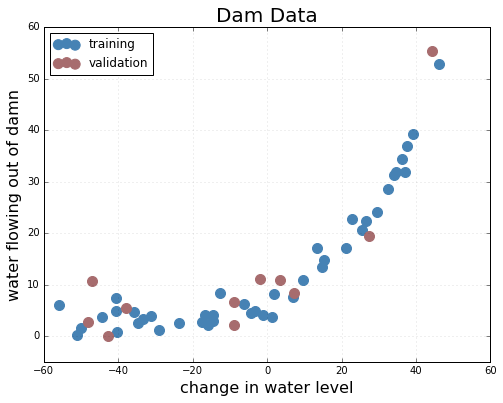

In [3]:
# import damn data 
with open("data/dam_regression.pickle", "rb") as fname: dam_data = pickle.load(fname)
X = dam_data["features"]
y = dam_data["response"]

# train-validation split 
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1734)

# plot the data 
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")])

**Part A**: Next we'll build a polynomial regression model to fit the data. Anticipating that we may want to do $\ell_2$-regularization at a later time, we'll use Scikit-Learn's [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) class. Use the link to check out the documentation. Notice that the class can be instantiated with several parameters, including a regularization parameter `alpha` (which is what we, and the rest of the civilized world, call $\lambda$). In addition to creating the polynomial features, we'll also standardize the features so that they play nicer with regularization.   

As a first pass, and to create a baseline, we'll start with a linear model with no regularization. 

In [4]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

degree, alpha = 1, 0
polyregcombo = [("poly", PolynomialFeatures(degree=degree, include_bias=False)),
                ("standardization", StandardScaler()),
                ("ridge", Ridge(alpha=alpha))]

linregpipe = Pipeline(polyregcombo)

So far we've only created an instance of the class.  Next we need to fit the model to our data.  Almost all models in Scikit-Learn come with a `.fit` method used to train the model.  We need to pass in the training features in `X_train` and the training responses in `y_train`. 

In [5]:
linregpipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=1, include_bias=False, interaction_only=False)), ('standardization', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

**Part B**: Next we'll make predictions on the training and validation sets and evaluate the mean-squared error. 

Training MSE:   45.296
Validation MSE: 100.367


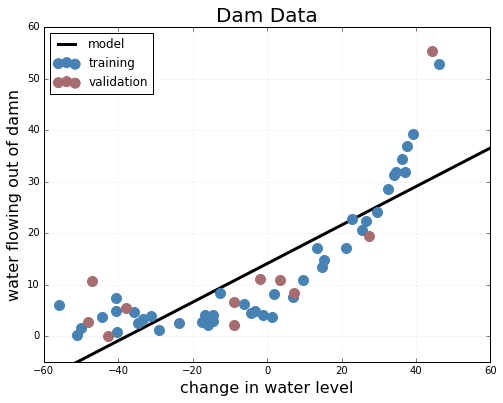

In [6]:
from sklearn.metrics import mean_squared_error

yhat_train = linregpipe.predict(X_train)
yhat_valid = linregpipe.predict(X_valid)

mse_train = mean_squared_error(yhat_train, y_train)
mse_valid = mean_squared_error(yhat_valid, y_valid)

print("Training MSE:   {:.3f}".format(mse_train))
print("Validation MSE: {:.3f}".format(mse_valid))

xplot = np.linspace(-60,60,100).reshape(-1,1)
yplot = linregpipe.predict(xplot) 
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")], [(xplot, yplot, "model")])

**Part C**: Next we'll fit a high-degree polynomial model with no regularization, which is very likely to overfit. 

In [7]:
degree, alpha = 9, 0
stand_combo = [("poly", PolynomialFeatures(degree=degree, include_bias=False)),
               ("stand", StandardScaler()),
               ("ridge", Ridge(alpha=alpha))]
deg9regpipe = Pipeline(stand_combo)

deg9regpipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=9, include_bias=False, interaction_only=False)), ('stand', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Again, we'll fit the model, print errors, and make a plot. How do the resulting errors and plot compare to the linear model? 

Training MSE:   2.514
Validation MSE: 16.240


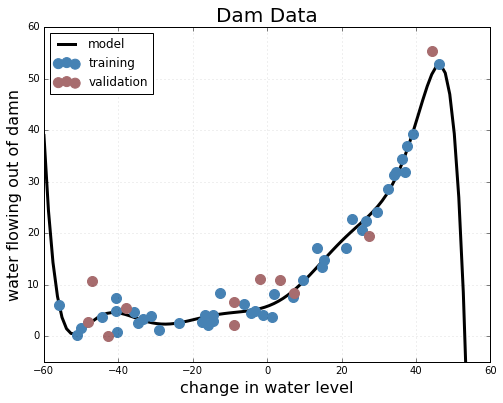

In [8]:
yhat_train = deg9regpipe.predict(X_train)
yhat_valid = deg9regpipe.predict(X_valid)

mse_train = mean_squared_error(yhat_train, y_train)
mse_valid = mean_squared_error(yhat_valid, y_valid)

print("Training MSE:   {:.3f}".format(mse_train))
print("Validation MSE: {:.3f}".format(mse_valid))

xplot = np.linspace(-60,60,100).reshape(-1,1)
yplot = deg9regpipe.predict(xplot) 
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")], [(xplot, yplot, "model")])

**Part D**: Unsurprisingly, the degree-9 model appears to overfit the training data.  Let's see if we can temper it a bit by using regularization.  Go back to the previous block and play with the regularization strength.  Can you zero in on a value of `alpha` ($\lambda$) that seems to work well? 

**Part E**: Let's see how we can systematically zero in on a good regularization parameter for the degree $9$ model. Typically what we'd do is run our model for many values of the regularization parameter and examine the MSE on the training and validation sets.  The optimal regularization parameter is then the place on the curve with the lowest validation error.  Scikit-Learn implements this functionality using something called a [validation_curve](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html#sklearn.model_selection.validation_curve). 

Interpret the validation curve.  How does the regularization parameter affect the validation and training error?  What value of the regularization strength appears to be optimal? 

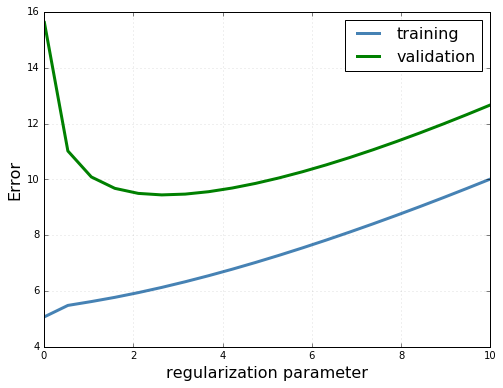

In [9]:
from sklearn.model_selection import validation_curve

lams = np.linspace(0.01, 10, 20)

neg_MSE_train_folds, neg_MSE_valid_folds = validation_curve(deg9regpipe, X, y, 
                                                            param_name="ridge__alpha", param_range=lams,
                                                            cv=5, scoring="neg_mean_squared_error")

MSE_train = -np.mean(neg_MSE_train_folds, axis=1)
MSE_valid = -np.mean(neg_MSE_valid_folds, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(lams, MSE_train, lw=3, color="steelblue", label="training")
ax.plot(lams, MSE_valid, lw=3, color="green", label="validation")
ax.grid(alpha=0.25)
ax.set_xlabel("regularization parameter", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.legend(loc="upper right", fontsize=16);

**Part F**: Eyeball (or compute exactly, if you can) the optimal value of the regularization strength.  Then create a new regularized model using the desired value of $\lambda,$ check MSE, make plots, etc. 

Degree 9 Train MSE:      2.514
Degree 9 Validation MSE: 16.240


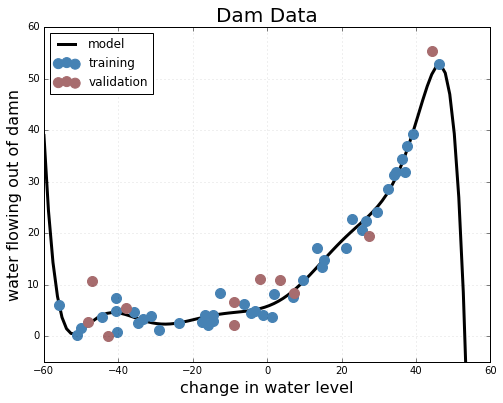

In [10]:
degree, alpha = 9, 0 # TODO 
reg_combo= [("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("stand", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))]
deg9optpipe = Pipeline(reg_combo)

deg9optpipe.fit(X_train, y_train)

yphat_train = deg9optpipe.predict(X_train)
yphat_valid = deg9optpipe.predict(X_valid)

print("Degree {:d} Train MSE:      {:.3f}".format(degree, mean_squared_error(yphat_train, y_train)))
print("Degree {:d} Validation MSE: {:.3f}".format(degree, mean_squared_error(yphat_valid, y_valid)))

xplot = np.linspace(-60,60,100).reshape(-1,1)
yplot = deg9optpipe.predict(xplot) 
dam_plot([(X_train, y_train, "training"), (X_valid, y_valid, "validation")], [(xplot, yplot, "model")])

**Part G**: Produce learning curves for the degree-9 polynomial model with no regularization and the one with optimal regularization strength.  Interpret the results in terms of the Bias-Variance Trade-Off. 

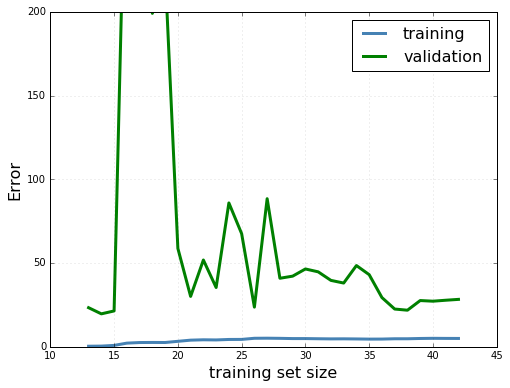

In [11]:
from sklearn.model_selection import learning_curve

train_sizes = np.array([13+ii for ii in range(43-13)])

train_sizes, neg_MSE_train_folds, neg_MSE_valid_folds = learning_curve(estimator=deg9regpipe, X=X, y=y,
                                                        train_sizes=train_sizes, cv=10,
                                                        scoring="neg_mean_squared_error") 

MSE_train = -np.mean(neg_MSE_train_folds, axis=1)
MSE_valid = -np.mean(neg_MSE_valid_folds, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(train_sizes, MSE_train, lw=3, color="steelblue", label="training")
ax.plot(train_sizes, MSE_valid, lw=3, color="green", label="validation")
ax.grid(alpha=0.25)
ax.set_xlabel("training set size", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.legend(loc="upper right", fontsize=16);
ax.set_ylim([0,200]);

Note that there is now a gigantic gap between the validation and training MSE, indicating that the method has **high variance** (as we would expect, since it's an unregularized high-degree polynomial regression).  Additionally, the training MSE is fairly low, indicating that the model has **low bias**. 

/Users/poorwa/anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/poorwa/anaconda/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/poorwa/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.10998292745653e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/poorwa/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision

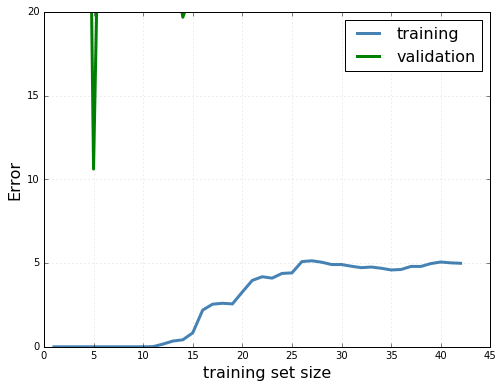

In [12]:
from sklearn.model_selection import learning_curve

train_sizes = np.array(range(1,43))

train_sizes, neg_MSE_train_folds, neg_MSE_valid_folds = learning_curve(estimator=deg9optpipe, X=X, y=y,
                                                        train_sizes=train_sizes, cv=10,
                                                        scoring="neg_mean_squared_error") 

MSE_train = -np.mean(neg_MSE_train_folds, axis=1)
MSE_valid = -np.mean(neg_MSE_valid_folds, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(train_sizes, MSE_train, lw=3, color="steelblue", label="training")
ax.plot(train_sizes, MSE_valid, lw=3, color="green", label="validation")
ax.grid(alpha=0.25)
ax.set_xlabel("training set size", fontsize=16)
ax.set_ylabel("Error", fontsize=16)
ax.legend(loc="upper right", fontsize=16);
ax.set_ylim([0,20]);

Note that with regularization we now have a fairly small gap between the validation and training MSE, indicating that the method has fairly **low variance**.  The training MSE is again pretty low, indicating that the model has fairly **low bias**. 


### Problem 2: Ridge Regression and Baseball Hitter Salaries
***

This problem was adopted from _Introduction to Statistical Learning_ by James, et. al. 

In this problem we'll look at how Ridge regularization affects the coefficients and performance of a multiple linear regression model to predict baseball salaries based on various stats. You can read descriptions of each of the features [here](https://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Hitters.html). 

Execute the following cell to load the data into a Pandas DataFrame, inspect it, and convert the data into numerical features. 

In [13]:
# read in the data and separate into features and response 
dfHitters = pd.read_csv("data/hitters.csv")
X, y = dfHitters.loc[:,dfHitters.columns != "Salary"].values*1.0, dfHitters.loc[:, "Salary"].values

# check out data 
dfHitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,LeagueN,DivisionW,Salary
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,1,1,475.0
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,0,1,480.0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,1,0,500.0
3,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,1,0,91.5
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,0,1,750.0


**Part A**: The first thing we'll do is perform a regularization study with Ridge regression to see how the regression parameters behave as the regularization strength increases. Run the following code and describe the effect of the regularization.  

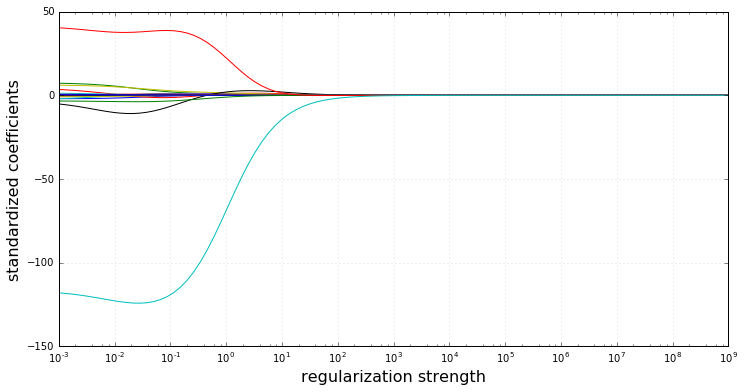

In [18]:
# define vector of lambdas 
lams = np.logspace(-3,9,100)

# fit ridge regression model for each lambda and save coefficients 
rreg = Ridge(normalize=True)
coefs = []
for lam in lams:
    rreg.set_params(alpha=lam)
    rreg.fit(X, y)
    coefs.append(rreg.coef_)

# plot the trajectory of each coefficient vs lambda 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(lams, coefs)
ax.set_xscale('log')
ax.set_xlabel('regularization strength', fontsize=16)
ax.set_ylabel('standardized coefficients', fontsize=16)
#plt.axis('tight')
ax.grid(alpha=0.25)

**Part B**: Next we'll look at the model parameters and model performance for various specific values of $\lambda$. First we'll split the data into train and validation sets.  Then we'll fit a Ridge regression model with `lam = 4`.  Note the size of the parameters and the validation MSE. Next, set `lam` to a very very large value.  What do you observe?  

In [19]:
# split the data into train and validation sets 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=1)

Ridge (lam = 4.000000) Validation MSE: 106281.6)


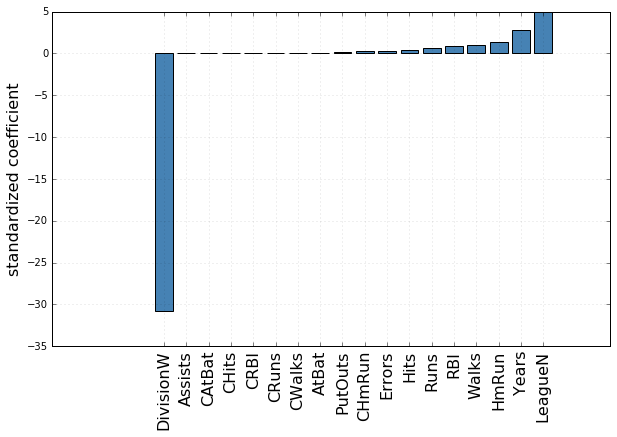

In [31]:
lam = 4
rreg= Ridge(alpha=lam, normalize=True)
rreg.fit(X_train, y_train)
pred_valid = rreg.predict(X_valid)

valid_MSE = np.mean((y_valid - pred_valid)**2)
print("Ridge (lam = {:f}) Validation MSE: {:.1f})".format(lam, valid_MSE))

coef_vis(rreg.coef_, dfHitters)

**Part C**: Is the regularization actually producing a better model?  Compare the validation MSE when `lam = 4` to the validation MSE for standard unregularized multiple linear regression. 

Ridge (lam = 0.000000) Validation MSE: 115169.7)


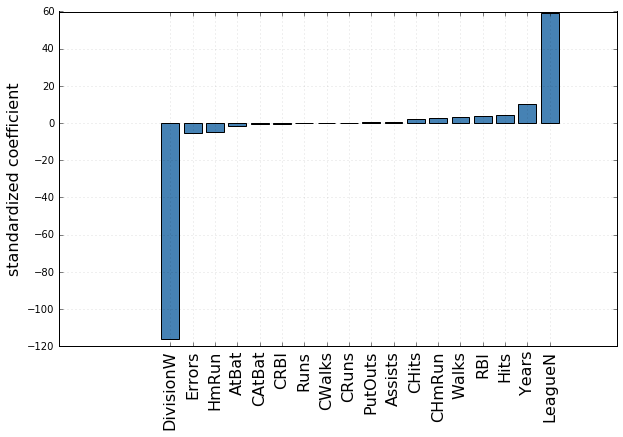

In [30]:

lam = 0
rreg= Ridge(alpha=lam, normalize=True)
rreg.fit(X_train, y_train)
pred_valid = rreg.predict(X_valid)

valid_MSE = np.mean((y_valid - pred_valid)**2)
print("Ridge (lam = {:f}) Validation MSE: {:.1f})".format(lam, valid_MSE))

coef_vis(rreg.coef_, dfHitters)

**Part D**: Next we'll perform cross-validation to choose an optimal value of `lam`.  We could do this by plotting a validation curve, but Scikit-Learn actually has a built in routine for finding the optimal `lam` in Ridge Regression. 

In [32]:
from sklearn.linear_model import RidgeCV

rregcv = RidgeCV(alphas = lams, scoring = 'neg_mean_squared_error', normalize = True)
rregcv.fit(X_train, y_train)
print("The optimal Ridge Regression Parameter is {:.3f}".format(rregcv.alpha_))

The optimal Ridge Regression Parameter is 0.614


**Part E**: Use the optimal regularization parameter to fit a new model and evaluate the MSE on the validation data. Is this an improvement over the other models we've looked at? 

Ridge (lam = 0.613591) Validation MSE: 99766.5)


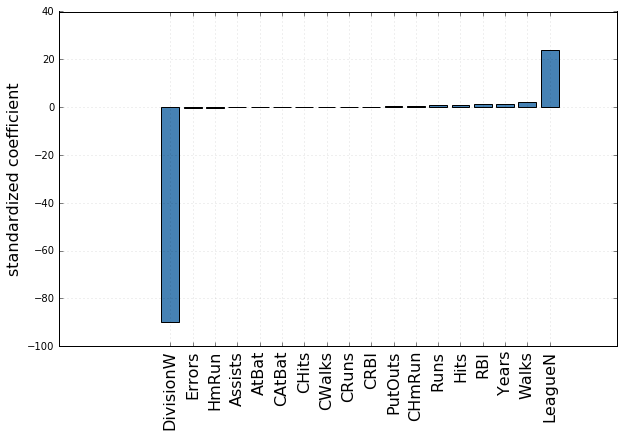

In [33]:
lam = rregcv.alpha_
rreg = Ridge(alpha=lam, normalize=True)
rreg .fit(X_train, y_train)
pred_valid = rreg.predict(X_valid)

valid_MSE = np.mean((y_valid - pred_valid)**2)
print("Ridge (lam = {:f}) Validation MSE: {:.1f})".format(lam, valid_MSE))

coef_vis(rreg.coef_, dfHitters)

**Part F**: Use the optimal value of `lam` to fit a model on the entirety of the data set.  Then inspect the model coefficients (better to print them then plot them).  What do you notice about the size of the model parameters? 

### Problem 3: Lasso and Baseball Hitter Salaries
***

This problem was adopted from _Introduction to Statistical Learning_ by James, et. al. 

We saw in the previous problem that Ridge Regression produces a better model than standard multiple linear regression.  Now we'll see how Lasso compares to the rest. 

**Part A**: The we'll perform a regularization study with Lasso to see how the regression parameters behave as the regularization strength increases. Run the following code and describe the effect of the regularization.  

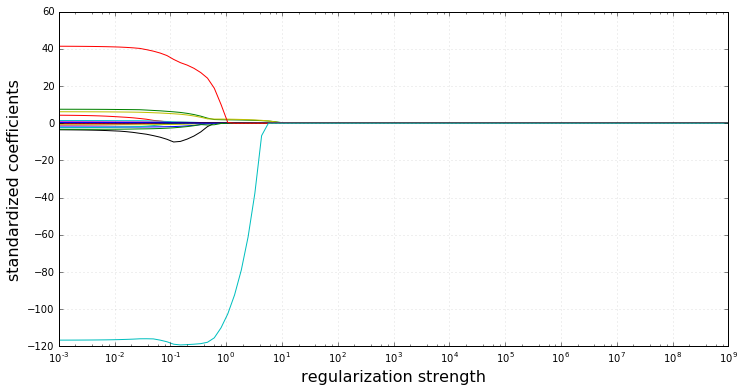

In [36]:
from sklearn.linear_model import Lasso, LassoCV 

# define vector of lambdas 
lams = np.logspace(-3,9,100)

# fit ridge regression model for each lambda and save coefficients 
lreg = Lasso(normalize=True, max_iter=10000)
coefs = []
for lam in lams:
    lreg.set_params(alpha=lam)
    lreg.fit(X, y)
    coefs.append(lreg.coef_)

# plot the trajectory of each coefficient vs lambda 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(lams, coefs)
ax.set_xscale('log')
ax.set_xlabel('regularization strength', fontsize=16)
ax.set_ylabel('standardized coefficients', fontsize=16)
#plt.axis('tight')
ax.grid(alpha=0.25)

**Part B**: Next we'll perform cross-validation to choose an optimal value of `lam`. Fit a Lasso model with the optimal regularization strength that you found.  Compute the validation MSE and compare it to the Ridge models you computed in Problem 2.   

In [37]:
from sklearn.linear_model import LassoCV

# run cross-validation and find optimal parameter 
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

print("The optimal Lasso Parameter is {:.3f}".format(lassocv.alpha_))

The optimal Lasso Parameter is 2.403


Lasso (lam = 2.402973) Validation MSE: 104960.7)


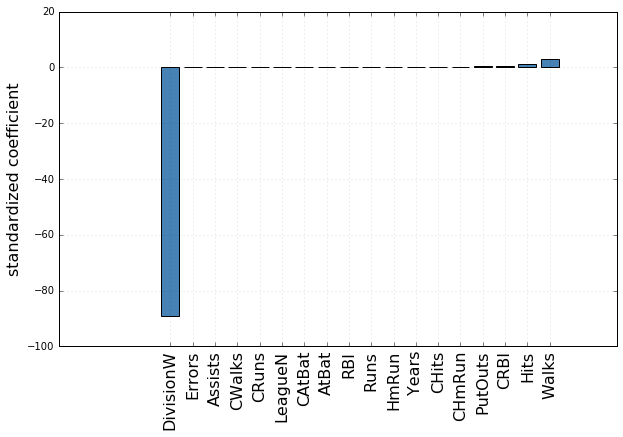

In [38]:
# fit Lasso model with optimal regularization strength 
lasso = Lasso(normalize=True, alpha=lassocv.alpha_, max_iter=100000)
lasso.fit(X_train, y_train)

# make predictions 
pred_valid = lasso.predict(X_valid)

# compute MSE 
valid_MSE = np.mean((y_valid - pred_valid)**2)
print("Lasso (lam = {:f}) Validation MSE: {:.1f})".format(lassocv.alpha_, valid_MSE))

# plot coefficients 
coef_vis(lasso.coef_, dfHitters)

**Part C**: The best validation MSE from Lasso is better than standard MLR, but is a little worse than the optimal result with Ridge Regression.  Why would we ever choose Lasso over Ridge regression then? 

<br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br>

### Helper Functions
***

In [1]:
def dam_plot(scatter=[], models=[]):
    '''
    Function to plot the dam data 
    '''
    
    # colors for scatter plots and model plots 
    scolors = ["steelblue", "#a76c6e", "#6a9373", "orange"]
    mcolors = ["black", "gray"]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
    
    # Loop over scatter data and make plots 
    for ii, (x, y, label) in enumerate(scatter):
        ax.scatter(x, y, s=100, color=scolors[ii], label=label, zorder=2)
        
    # Loop over model data and make plots 
    for ii, (xplot, yplot, label) in enumerate(models):
        ax.plot(xplot, yplot, color=mcolors[ii], lw=3, label=label, zorder=1)
        
    # Set axis limits
    ax.set_xlim([-60,60])
    ax.set_ylim([-5,60])
        
    # Label all the things 
    ax.set_xlabel("change in water level", fontsize=16)
    ax.set_ylabel("water flowing out of damn", fontsize=16)
    ax.set_title("Dam Data", fontsize=20); ax.grid(alpha=0.25)
    ax.legend(loc="upper left", fontsize=12);
    
def coef_vis(coef, df):
    '''
    Function to plot MLR parameters 
    '''
    feat_names = df.columns.values[:-1]
    sinds = np.argsort(coef)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    ax.bar(range(len(coef)), coef[sinds], color="steelblue", align="center")
    ax.set_ylabel("standardized coefficient", fontsize=16)
    ax.grid(alpha=0.25)
    ax.set_xticks(range(len(coef)))
    ax.set_xticklabels(feat_names[sinds], rotation='vertical', fontsize=16)